# Final Project Basic Python 

In the following notebook we use the deep learning library Keras to predict whether a person has diabetes or not. The data we use originally stems from UCI Machine Learning. 
We followed a Tutorial (https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/) to get a first grip on the topic of deep learning and expanded on it. 
All code we took from the tutorial is marked as "from tutorial"

In [48]:
import numpy as np
from matplotlib import pyplot
from numpy import loadtxt

import sklearn as sk
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow import keras
from keras.utils.vis_utils import plot_model
import seaborn as sns
import pandas as pd

In [6]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

## Data Preprocessing

In [12]:
# load the dataset
dataset = pd.read_csv('https://raw.githubusercontent.com/MagMueller/BasicPython/main/pima-indians-diabetes.csv', delimiter=',', names=["Number of pregnancies", "Plasma glucose", "mm Hg blood press.", "Triceps skin thickness", "2 hour serum insulin mu U per ml", "bmi", "pedigree diabetes function", "age"])


After loading the data we convert it to a pandas dataframe which will facilitate further processing. After that we want to get a first overview over the data.

In [13]:
df = pd.DataFrame.from_records(dataset)
print("length of dataset: {}".format(len(df)))
df.head()

length of dataset: 768


,Number of pregnancies,Plasma glucose,mm Hg blood press.,Triceps skin thickness,2 hour serum insulin mu U per ml,bmi,pedigree diabetes function,age
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1


We now know that our dataframe has 768 rows and 9 columns. In order to improve readibility and facilitate the handling of the data we added meaningful names to the columns.

In [14]:

df.columns = ["Pregnancies", "Plasma gluc conc", 
              "Blood pressure", "Skin thickness", 
              "Serum-insulin", "BMI", "Diabetis pedigree func", 
              "Age", "has diabetes"]
df.head()

ValueError: ignored

We now check whether the data comprises any NAs.

In [15]:
df.isna().sum()

Number of pregnancies               0
Plasma glucose                      0
mm Hg blood press.                  0
Triceps skin thickness              0
2 hour serum insulin mu U per ml    0
bmi                                 0
pedigree diabetes function          0
age                                 0
dtype: int64

Since there are no NAs in the dataset we can move on to get a more detailed overview over our data by using pandas describe function. The produced dataframe is then transposed to improve readability.

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Number of pregnancies,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Plasma glucose,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
mm Hg blood press.,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Triceps skin thickness,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
2 hour serum insulin mu U per ml,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
bmi,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
pedigree diabetes function,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
age,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


We can see that the min of some measurements is 0 where it is clearly only a replacement for NAs (eg. Blood pressure, BMI..). So we replace these missing measurements with a better substitution, which will  namely the median of the respective variable 

In [17]:


# We exclude the first and the last column since 0 is a plausible value for them
for colname in df.columns[1:-1]: 
    col = df[colname] #select the individual column 
    col[col == 0.000] = col.median() #replace the every instance of value 0 with the median of the column


df.describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying

,count,mean,std,min,25%,50%,75%,max
Number of pregnancies,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Plasma glucose,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
mm Hg blood press.,768.0,27.334635,9.229014,7.000,23.00000,23.0000,32.00000,99.00
Triceps skin thickness,768.0,94.652344,105.547598,14.000,30.50000,31.2500,127.25000,846.00
2 hour serum insulin mu U per ml,768.0,32.450911,6.875366,18.200,27.50000,32.0000,36.60000,67.10
bmi,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
pedigree diabetes function,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
age,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


We can see that for Serum insulin the values range from 14 to 846 while for the diabetes pedigree function the values values stay between 0.078 and 2.42. This large disparity of value size could yield problems in the learning process, therefore we normalized the data by dividing every item of a column by the maximum value of the column.

In [18]:
#normalize by deviding every element of the dataframe by the maximum value of the dataframe
df_unscaled = df.copy()
for column in df.columns:
    df[column] = df[column]  / df[column].abs().max()


df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Number of pregnancies,768.0,0.607510,0.160666,0.000000,0.497487,0.587940,0.704774,1.0
Plasma glucose,768.0,0.593334,0.099153,0.196721,0.524590,0.590164,0.655738,1.0
mm Hg blood press.,768.0,0.276107,0.093222,0.070707,0.232323,0.232323,0.323232,1.0
Triceps skin thickness,768.0,0.111882,0.124761,0.016548,0.036052,0.036939,0.150414,1.0
2 hour serum insulin mu U per ml,768.0,0.483620,0.102464,0.271237,0.409836,0.476900,0.545455,1.0
bmi,768.0,0.194990,0.136913,0.032231,0.100723,0.153926,0.258781,1.0
pedigree diabetes function,768.0,0.410381,0.145188,0.259259,0.296296,0.358025,0.506173,1.0
age,768.0,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.0


KeyError: ignored

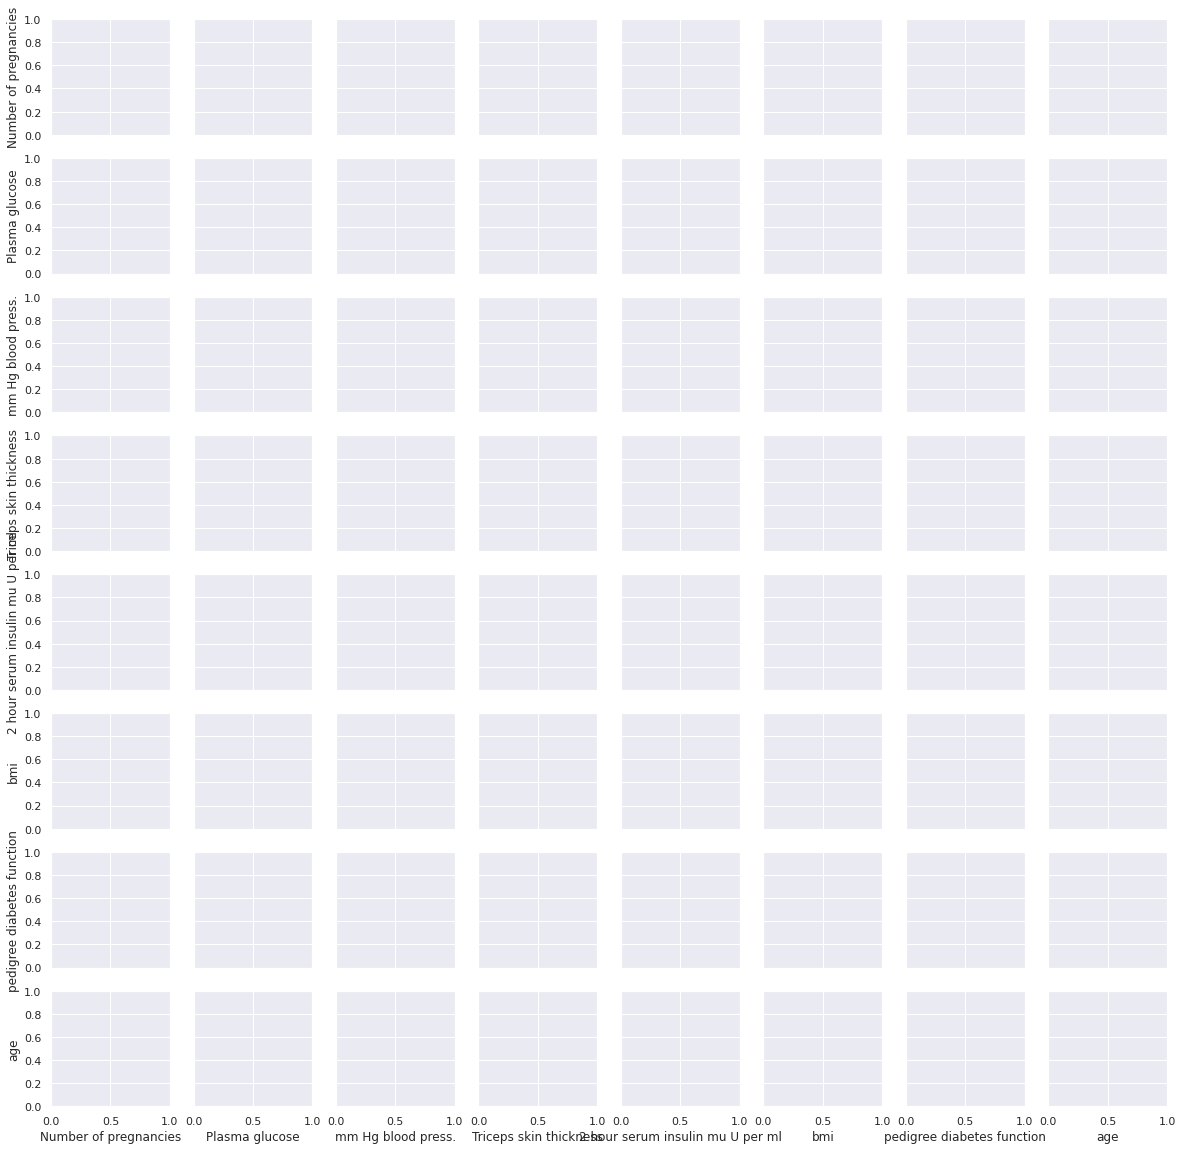

In [19]:
#As a next step we decided to use seaborns pairplot function in order to see the relation of every pair of
#variable in the dataset. The variable "has diabetes" was left out and instead used to seperate the 
#datapoints in every subplot into two groups by colour. 
sns.set()
sns.pairplot(df_unscaled, hue = "has diabetes")

In [ ]:

df2 = pd.melt(df, df.columns[-1], df.columns[:-1])
g = sns.FacetGrid(df2, col="variable", col_wrap=4, hue = "has diabetes")
g = g.map(lambda y, **kw: plt.axvline(y.mean(), color = "red"), 'value') 
g.map(sns.kdeplot, "value", shade=True)
g.add_legend()
#legend = g.legend
#labels = ['has diabetes', 'has no diabetes']
#for t, l in zip(legend.texts, labels): t.set_text(l)

C:\Users\fsele\anaconda3\envs\scipy\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


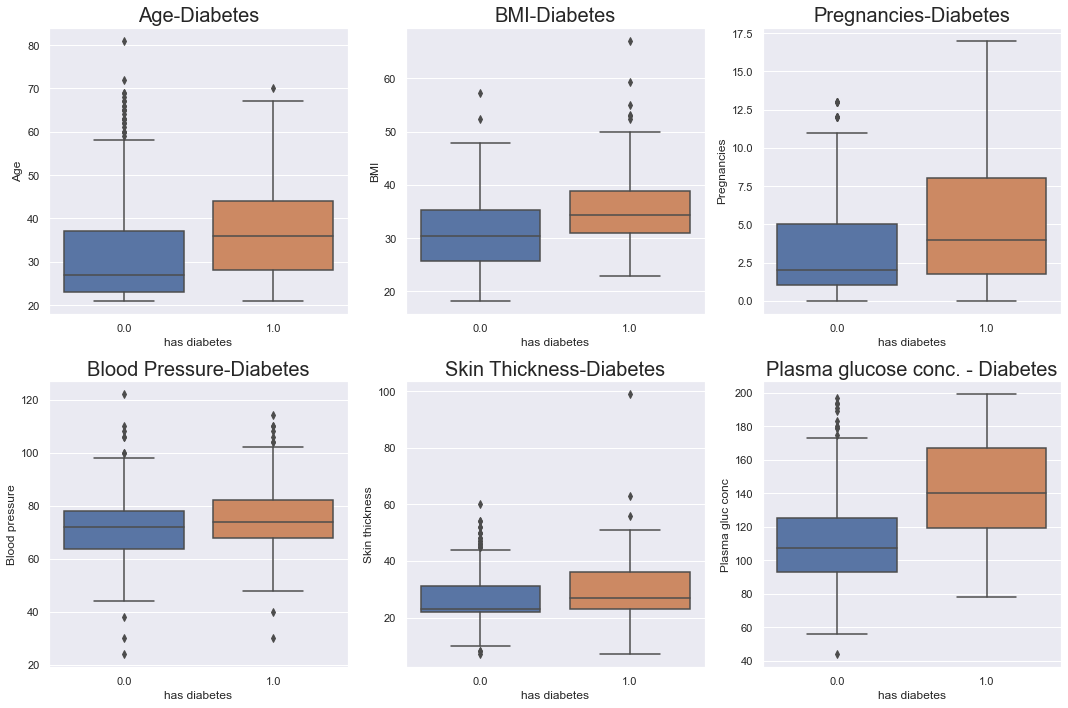

In [ ]:
#Since plotting in such high dimension becomes overcomplicated very fast, we decided to 
# do a few lower dimensional plots.
fig, (ax1, ax2) = plt.subplots(2,3, figsize= (15,10))
sns.boxplot(x='has diabetes', y='Age', data=df_unscaled, ax = ax1[0])
sns.boxplot(x='has diabetes', y='BMI', data=df_unscaled, ax = ax1[1])
sns.boxplot(x='has diabetes', y='Pregnancies', data=df_unscaled, ax = ax1[2])
sns.boxplot(x='has diabetes', y='Blood pressure', data=df_unscaled, ax = ax2[0])
sns.boxplot(x='has diabetes', y='Skin thickness', data=df_unscaled, ax = ax2[1])
sns.boxplot(x='has diabetes', y='Plasma gluc conc', data=df_unscaled, ax = ax2[2])
ax1[0].set_title("Age-Diabetes" , fontsize = 20)
ax1[1].set_title("BMI-Diabetes" , fontsize = 20)
ax1[2].set_title("Pregnancies-Diabetes" , fontsize = 20)
ax2[0].set_title("Blood Pressure-Diabetes" , fontsize = 20)
ax2[1].set_title("Skin Thickness-Diabetes" , fontsize = 20)
ax2[2].set_title("Plasma glucose conc. - Diabetes", fontsize = 20)
fig.tight_layout()

fig.show()

From our plots we now know how the data is distributed in the respective variable and we 
           

Now we have a sufficient idea about our data, so we can continue to prepare the data for our actual Keras model. 
Firstly, we split the data into input variables (X) and output variables (Y). The input variables contain the information upon which the output variable is supposed to be predicted.
At the same time we split the data into 90% train and 10% test data 

In [46]:
X_train = df.iloc[0:int(len(df) * 0.9), 0:8]
X_test = df.iloc[int(len(df) * 0.9):, 0:8]
y_train = df.iloc[0:int(len(df) * 0.9), 8]
y_test = df.iloc[int(len(df) * 0.9):, 8]

IndexError: ignored

In [ ]:
len(X_train)

691

In [ ]:
train_mean = X_train.mean()
train_std = X_train.std()

train_df = (X_train - train_mean) / train_std
test_df = (X_test - train_mean) / train_std

In [ ]:
df

,Pregnancies,Plasma gluc conc,Blood pressure,Skin thickness,Serum-insulin,BMI,Diabetis pedigree func,Age,has diabetes
0,0.352941,0.743719,0.590164,0.353535,0.036052,0.500745,0.259091,0.617284,1.0
1,0.058824,0.427136,0.540984,0.292929,0.036052,0.396423,0.145041,0.382716,0.0
2,0.470588,0.919598,0.524590,0.232323,0.036052,0.347243,0.277686,0.395062,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.069008,0.259259,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.945455,0.407407,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.070661,0.777778,0.0
764,0.117647,0.613065,0.573770,0.272727,0.036052,0.548435,0.140496,0.333333,0.0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.101240,0.370370,0.0
766,0.058824,0.633166,0.491803,0.232323,0.036052,0.448584,0.144215,0.580247,1.0


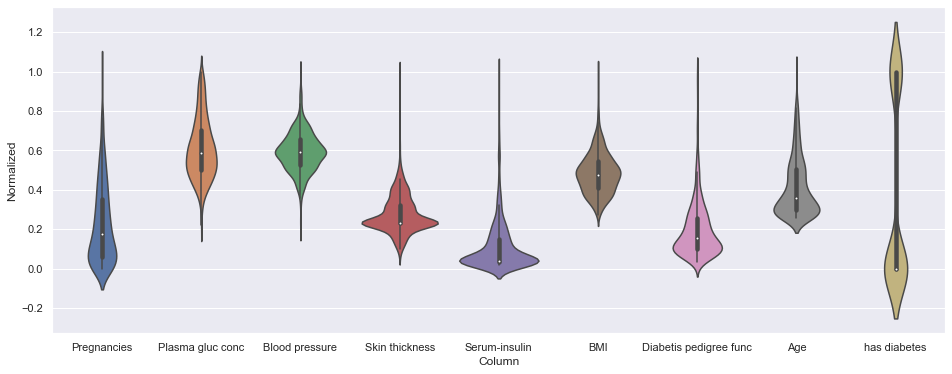

In [ ]:
#df_std = (df - train_mean) / train_std
df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std[df_std["Column"] != 4])
#_ = ax.set_xticklabels(dataset.keys(), rotation=90)

# **Correlation**

In the following section I will check the correlation between the features to see which features are relevant.

In [26]:
# load the dataset again
dataset = pd.read_csv('https://raw.githubusercontent.com/MagMueller/BasicPython/main/pima-indians-diabetes.csv', delimiter=',', names=["Number of pregnancies", "Plasma glucose", "mm Hg blood press.", "Triceps skin thickness", "2 hour serum insulin mu U per ml", "bmi", "pedigree diabetes function", "age", "result"])
# assert no empty data
assert(dataset.isnull().values.any() == False)

dataset.corr()

,Number of pregnancies,Plasma glucose,mm Hg blood press.,Triceps skin thickness,2 hour serum insulin mu U per ml,bmi,pedigree diabetes function,age,result
Number of pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Plasma glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
mm Hg blood press.,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
Triceps skin thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
2 hour serum insulin mu U per ml,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
pedigree diabetes function,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
result,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


We see that age is strongly correlated to the number of pregnancies. This is an expected result, so we can think that indeed this data seems correct. Furthermore we can see that blood pressure is connected to the 2 hour insulin concentration. The triceps skin seems then connected to the blood pressure too but also to the number of  pregnancies. Last but not least the plasma glucose level seems to be heavily correlated to the outcome as well as a slight correlation of outcome and bmi. We identify no other strongly correlated factors. To use less data at this point we could deduce that we can stop using triceps skin thickness as it is connected to two other values used and also influenced by pregnancy, which in itself it slightly related to the outcome.

# **Data preparation and splits**

## Split data

In [49]:
features = (dataset.iloc[:,:8]).values
target = (dataset.loc[:,'result']).values

# dataset sizes
testSize = 0.3 #%
trainSize = 0.7 #%
validSize = 0.5 #%

# train test split https://stackoverflow.com/a/51006816/16329933
x_train, x, y_train, y = train_test_split(features,target,train_size = trainSize)
x_val, x_test, y_val, y_test = train_test_split(x,y,train_size=validSize)

print("Sizes of")
print("x_train:    ",len(x_train))
print("y_train:    ",len(y_train))
print("x_val:      ",len(x_val))
print("y_val:      ",len(y_val))
print("x_test:     ",len(x_test))
print("y_test:     ",len(y_test))

Sizes of
x_train:     537
y_train:     537
x_val:       115
y_val:       115
x_test:      116
y_test:      116


Prepare the SVM data using a RobustScaler with modified quantiles.

In [64]:
# modified RobustScaler, using 30,70 quantile ranges
svm_scaler = sk.preprocessing.RobustScaler(with_centering=True,with_scaling=True,quantile_range=(30.0, 70.0),copy=True)
x_train_svm = svm_scaler.fit_transform(x_train)
x_val_svm  = svm_scaler.fit_transform(x_val)
x_test_svm = svm_scaler.fit_transform(x_test)

## SVM

In [75]:
support_vector_classifier = sk.svm.SVC(kernel='rbf',class_weight = 'balanced',random_state = 1)

# train the svm
support_vector_classifier.fit(x_train_svm,y_train)

# validate the classifier
y_pred = support_vector_classifier.predict(x_val_svm)

# print the accuracy and store it
print("__ SVM METRICS __")
met = sk.metrics.accuracy_score(y_val, y_pred)
print("Accuracy:",met)

accuracy_svm = met

print(sk.metrics.classification_report(y_val, y_pred, digits=3, output_dict=False))

__ SVM METRICS __
Accuracy: 0.782608695652174
              precision    recall  f1-score   support

           0      0.871     0.792     0.830        77
           1      0.644     0.763     0.699        38

    accuracy                          0.783       115
   macro avg      0.758     0.778     0.764       115
weighted avg      0.796     0.783     0.787       115



## Define the Keras model

In [9]:
# define the keras model
model = Sequential()  #taken from tutorial
model.add(Dense(8, input_dim=8, activation='relu')) #taken from tutorial
model.add(Dense(16, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #taken from tutorial

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 100       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 773
Trainable params: 773
Non-trainable params: 0
__________________________________________________________

In [11]:
from keras.utils.vis_utils import plot_model
#model = Sequential()
#model.add(Dense(2, input_dim=1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AssertionError: ignored

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0) #

In [ ]:
print(history.history.keys())

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluate

In [ ]:
# evaluate the keras model on train data
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

22/22 [==============================] - 0s 997us/step - loss: 0.4405 - accuracy: 0.7786
Accuracy: 77.86


In [ ]:
# evaluate the keras model on test data
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

3/3 [==============================] - 0s 1ms/step - loss: 0.4823 - accuracy: 0.7922
Accuracy: 79.22


In [ ]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [ ]:
predictions[:10]

array([[0.8158914 ],
       [0.49337548],
       [0.65206957],
       [0.01959831],
       [0.31814367],
       [0.6354721 ],
       [0.01845321],
       [0.31876305],
       [0.64353067],
       [0.23096713]], dtype=float32)

In [ ]:
y_test[691 + i]

NameError: name 'i' is not defined

In [ ]:
# summarize the first 5 cases
for i in range(20):
    print('%s %s => %d (expected %d)' % ("correct" if rounded[i] == y_test[691 + i] else "incorrect",round(X.iloc[i],2).tolist(), rounded[i], y_test[691 + i]))

# Random forest


In [ ]:
# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
#use unnormilized data for RF
#df_unscaled
# split into input (X) and output (y) variables
X_train = df_unscaled.iloc[0:int(len(df) * 0.9), 0:8]
X_test = df_unscaled.iloc[int(len(df) * 0.9):, 0:8]
y_train = df_unscaled.iloc[0:int(len(df) * 0.9), 8]
y_test = df_unscaled.iloc[int(len(df) * 0.9):, 8]

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 6)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
rounded = [round(x) for x in predictions]
# Calculate the absolute errors
errors = abs(rounded - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


In [ ]:
# summarize the first 5 cases
for i in range(20):
    print('%s %s => %d (expected %d)' % ("correct" if rounded[i] == y_test[691 + i] else "incorrect",round(X.iloc[i],2).tolist(), rounded[i], y_test[691 + i]))

In [ ]:
accuracy = np.sum(rounded == y_test)/len(y_test) * 100
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:

# Pull out one tree from the forest
tree = rf.estimators_[5]

In [ ]:
#Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',  rounded = True, precision = 1, 
                feature_names = ["Pregnancies", "Plasma gluc conc", "Blood pressure", "Skin thickness", "Serum-insulin", "BMI", "Diabetis pedigree func", "Age"],
                class_names = ["has diabetes"])

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Display in jupyter notebook
from IPython.display import image
image(filename = 'tree.png')

If the value in the leaves is < 0.5, the tree would say that the patient has no diabetes.